In [288]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp
import jax
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM, LinearAutoregressiveHMM

import os
import glob
import h5py
import pandas as pd
from functools import reduce
from scipy.signal import butter, filtfilt

from joblib import Parallel, delayed

In [138]:
#utils
def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data, subjects

def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors


def filter(data, fs, cutoff, filter_type, order):

    filtered_data = []
    for bold in data:
        filtered_bold = butterworth_filter(bold, fs, cutoff, filter_type, order)
        filtered_data.append(filtered_bold)

    return filtered_data

def butterworth_filter(matrix, fs, cutoff, filter_type='high', order=3):
    """
    Applies high-pass or band-pass Butterworth filter to a parcels × time matrix.
    
    Args:
        matrix: 2D array (parcels × time steps)
        fs: Sampling frequency (Hz)
        cutoff: Cutoff frequency/frequencies:
            - Single value for high-pass (e.g., 0.01)
            - Tuple/list for band-pass (e.g., [0.01, high_cutoff])
        filter_type: 'high' or 'band'
        order: Filter order (default=3)
    
    Returns:
        Filtered matrix with same shape as input
    """
    # Input validation
    if filter_type == 'band' and not isinstance(cutoff, (list, tuple)):
        raise ValueError("For band-pass, cutoff must be a list/tuple of [low, high]")
    
    # Design filter
    nyq = 0.5 * fs
    if filter_type == 'high':
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
    elif filter_type == 'band':
        normal_cutoff = [c / nyq for c in cutoff]
        b, a = butter(order, normal_cutoff, btype='band', analog=False)
    
    # Apply zero-phase filtering
    filtered = filtfilt(b, a, matrix, axis=1)  # Axis 1 assumes time is columns
    
    return filtered


def remove_movement(data, subjects, fd):

    good_data = []
    for n, subj in enumerate(subjects):
        subj_idx = fd.index[fd.iloc[:, 0] == subj].to_list()
        if not subj_idx:  # Subject not found case
            print(f"Warning: Subject {subj} not found in FD file. Skipping.")
            continue

        movement = fd.iloc[subj_idx, 1:]
        bold = data[n]
        no_move = np.squeeze(movement < 0.5)
        good_points = bold[:, no_move]
        good_data.append(good_points)

    return good_data


def load_events(data_root, subjects, file_pattern):
    data = []
    subj_folder = ["sub-" + sub.replace("_", "") for sub in subjects]
    folders = [os.path.join(data_root, sub, 'func') for sub in subj_folder]
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                data.append(pd.read_csv(file_path, sep='\t'))
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data

def calculate_volume_pattern(events, tr, n_volumes):

    volume_pattern = np.zeros((len(events), n_volumes))
    for nsubj, event_df in enumerate(events):
        nevents = len(event_df)
        onsets = event_df["onset"].to_numpy()
        onsets = np.floor(onsets / tr)
        durations = event_df["duration"].to_numpy()
        durations = np.floor(durations / tr)
        mapping = {value: index for index, value in enumerate(event_df['trial_type'].unique())}
        trial_types = (event_df['trial_type'].map(mapping)).to_numpy()
        for trial in range(0,nevents):
            onset = int(onsets[trial])
            duration = int(durations[trial])
            trial_type = trial_types[trial]
            volume_pattern[nsubj, onset:(onset+duration)] = trial_type + 1

    return volume_pattern


def get_info(data, column, subjects):
    infos = []
    for subj in subjects:
        subj_idx = data.index[data.iloc[:, 0] == subj].to_list()
        info = data[column].iloc[subj_idx].item()
        infos.append(info)

    return infos




In [143]:
# Load the data
data_root = "/home/zenari/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "task-hammer*.h5"
data, subjects = load_fmri(data_root, file_filter)

No files found matching task-hammer*.h5 in NDAR_INVBL062HTE
No files found matching task-hammer*.h5 in NDAR_INVBY805EE5
No files found matching task-hammer*.h5 in NDAR_INVGB371PPV
No files found matching task-hammer*.h5 in NDAR_INVGT021UPR
No files found matching task-hammer*.h5 in NDAR_INVHA329EL1
No files found matching task-hammer*.h5 in NDAR_INVLL260KC0
No files found matching task-hammer*.h5 in NDAR_INVPF283TAQ
No files found matching task-hammer*.h5 in NDAR_INVRR054KAM
No files found matching task-hammer*.h5 in NDAR_INVUA181LXU
No files found matching task-hammer*.h5 in NDAR_INVVU614ZKP
No files found matching task-hammer*.h5 in NDAR_INVXR625UBQ
No files found matching task-hammer*.h5 in NDAR_INVXV404VJL
No files found matching task-hammer*.h5 in NDAR_INVYT858CBN
No files found matching task-hammer*.h5 in NDAR_INVZH090MNG
No files found matching task-hammer*.h5 in NDAR_INVZU586UPF


In [140]:
print('Number of fMRI:', len(subjects))
print('Shape of example fMRI:', data[0].shape)

Number of fMRI: 226
Shape of example fMRI: (434, 493)


In [167]:
# Filtered list containing only elements with the expected shape
expected_shape = (434, 493)

selected_subjects = np.array( [subject for n, subject in enumerate(subjects) if data[n].shape[1]==expected_shape[1]] )

print('Initial number of fMRI:', len(data))
data_complete_task = [sub for sub in data if sub.shape == expected_shape]
print('Final number of fMRI:', len(data_cleaned))

Initial number of fMRI: 226
Final number of fMRI: 219


In [185]:
TR = 0.8
data_filtered= filter(data_complete_task, fs= 1/TR, cutoff=0.01, filter_type='high', order=2)

#remove movement
fd = pd.read_csv('/home/zenari/data/motion_FD/TCP_FD_hammer_AP.csv', sep=',', header=None)
data_no_mov = remove_movement(data_filtered, selected_subjects, fd)

In [252]:
#Subsampling the data

data_to_consider = data_filtered

n = 219 #number of fMRI
n_sample = np.random.randint(0, len(data_to_consider), n)

data_sub = [data_to_consider[i] for i in range(n)]

data_sub = np.array(data_sub)

data_sub.shape


(219, 434, 493)

In [253]:
### diagnosis
demo = pd.read_csv("/home/zenari/data/demos.tsv", sep=',', skiprows=1, encoding="latin1")
diagnoses = get_info(demo, 'Primary_Dx', selected_subjects)

controls = [1 if d == '999' else 0 for d in diagnoses]

len(controls), len(diagnoses), len(selected_subjects)

(219, 219, 219)

In [191]:
#Zscore the data
data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data_sub
    ])    

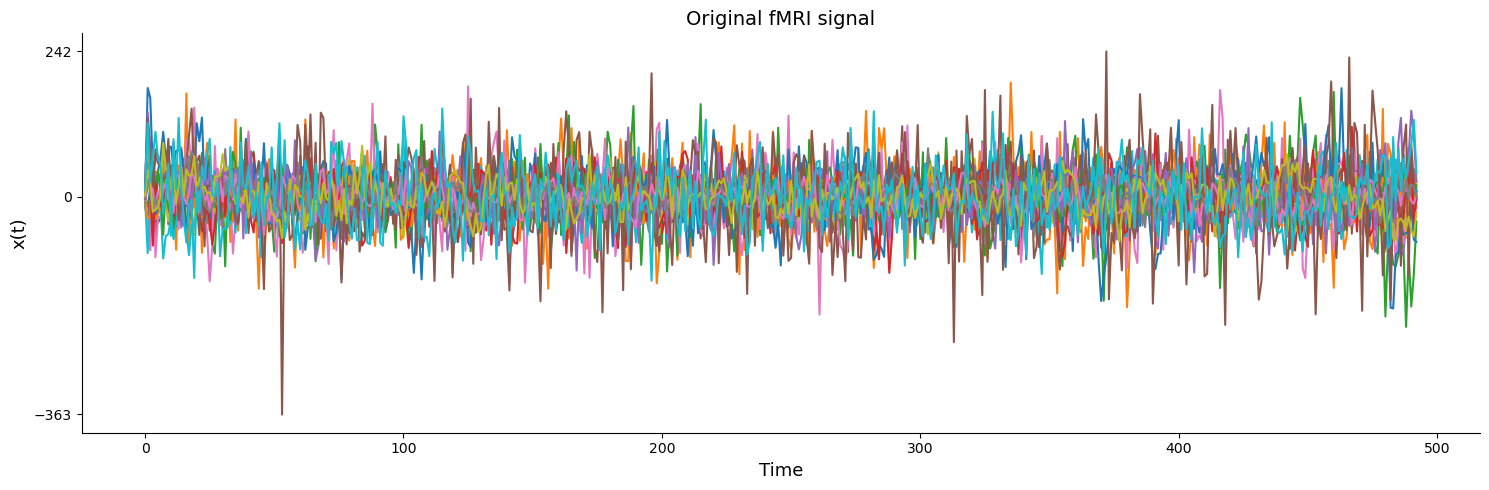

In [192]:
#plotting original sample
k = np.random.randint(0, n)
plot_signals(data_sub[k].T, dt = 1, n_plot=20, n_parcels=data_sub[k].shape[1], title='Original fMRI signal', figsize=(15, 5))

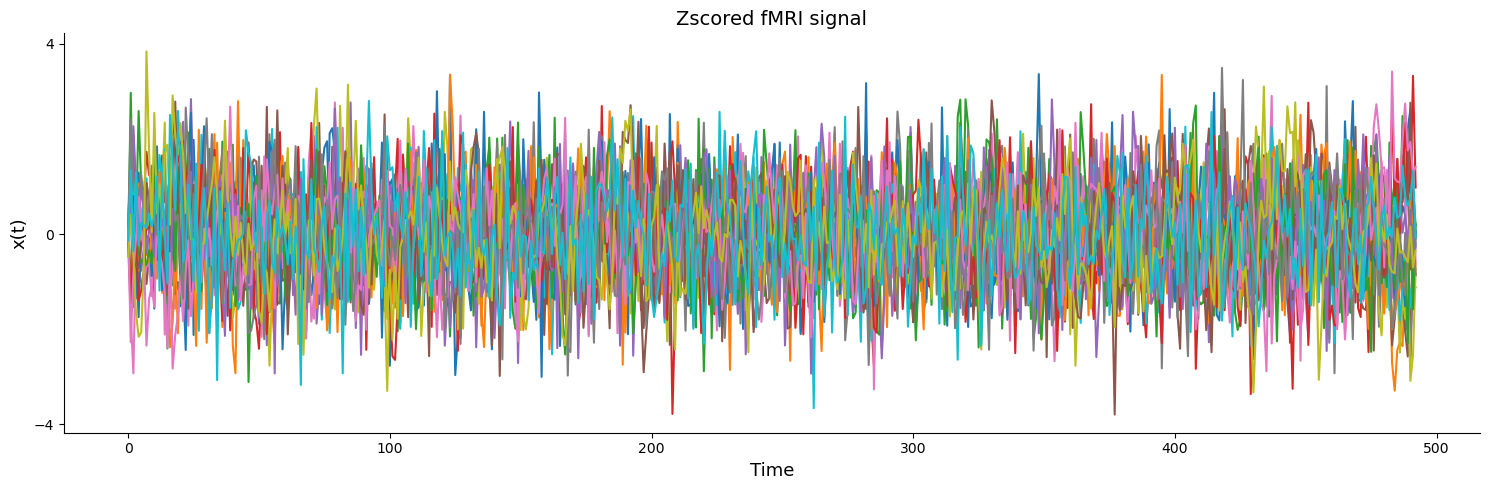

In [193]:
#plotting zscored sample  
plot_signals(data_zsc[k].T, dt = 1, n_plot=20, n_parcels=data_zsc[k].shape[1], title='Zscored fMRI signal', figsize=(15, 5))

In [194]:
print('Shape of the data:', data_zsc.shape)

n_subject = data_zsc.shape[0]
n_parcels = data_zsc.shape[1]
n_time = data_zsc.shape[2]

print('Number of subjects:', n_subject)
print('Number of parcels:', n_parcels)
print('Number of time points:', n_time)

Shape of the data: (219, 434, 493)
Number of subjects: 219
Number of parcels: 434
Number of time points: 493


In [230]:
#loading events
events = load_events('/home/zenari/data/events/', selected_subjects, '*hammer*')

stimuli = calculate_volume_pattern(events, TR, n_time)

In [361]:
### concatenating the data
x = data_zsc.transpose(1, 0, 2).reshape(n_parcels, n_time * n_subject)
print('Shape of the concatenated data:', x.shape)
total_time_points = x.shape[1] 

Shape of the concatenated data: (434, 107967)


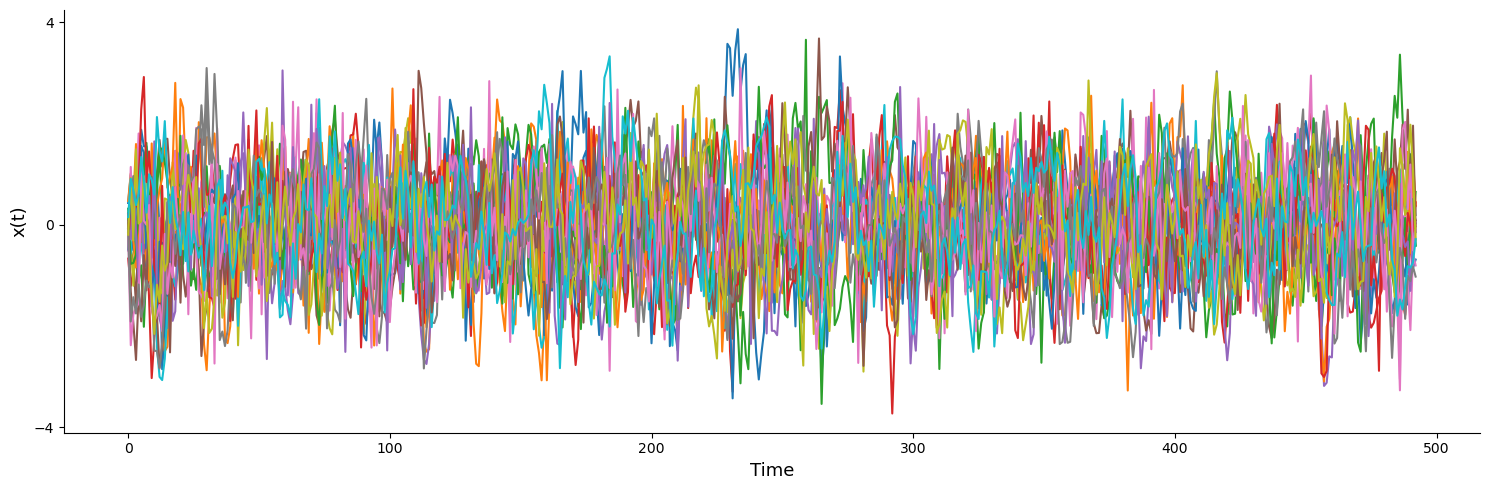

In [196]:
plot_signals(x[:, :n_time].T, dt = 1, n_plot=20, n_parcels=20, figsize=(15, 5))

In [197]:
#checking for Nan
np.isnan(x).any()

False

### PCA

In [270]:
projections, explained_variance_ratio, eigenvectors = compute_pca(x.T, n_parcels)

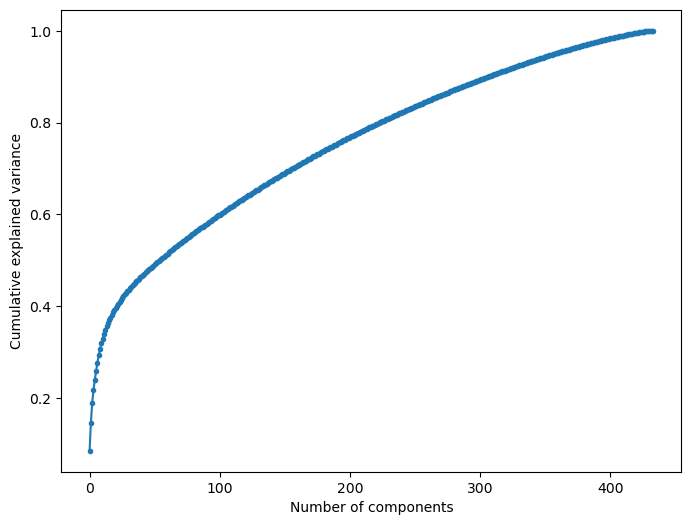

In [433]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), '.-')
#plt.plot(np.cumsum(explained_variance_ratio_mean), '.-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
#plt.axvline(20)
#plt.xlim(0, 30)
plt.show()

### Choosing the number of components

Text(0, 0.5, 'Derivative of variance explained')

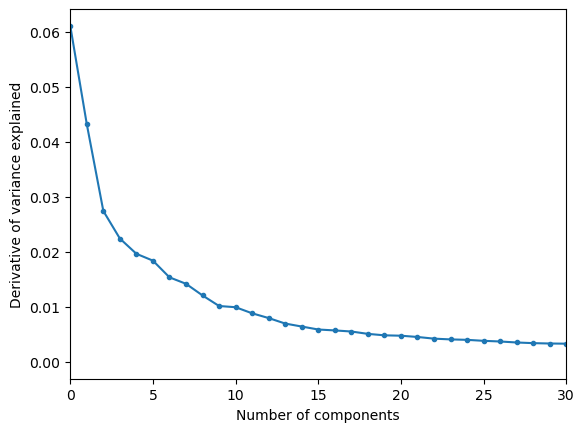

In [425]:
deriv_explained_variance_ratio = np.diff(np.cumsum(explained_variance_ratio))
plt.plot(deriv_explained_variance_ratio, '.-')
plt.xlim(0, 30)
plt.xlabel('Number of components')
plt.ylabel('Derivative of variance explained')

In [ ]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1                  # Initial state probs (sum to 1)
    transitions = K * (K - 1)           # Rows of transition matrix sum to 1
    means = K * D                       # One mean vector per state
    covs = K * D * (D + 1) // 2         # One full cov matrix per state
    return init_probs + transitions + means + covs

In [445]:
total_time_points

107967

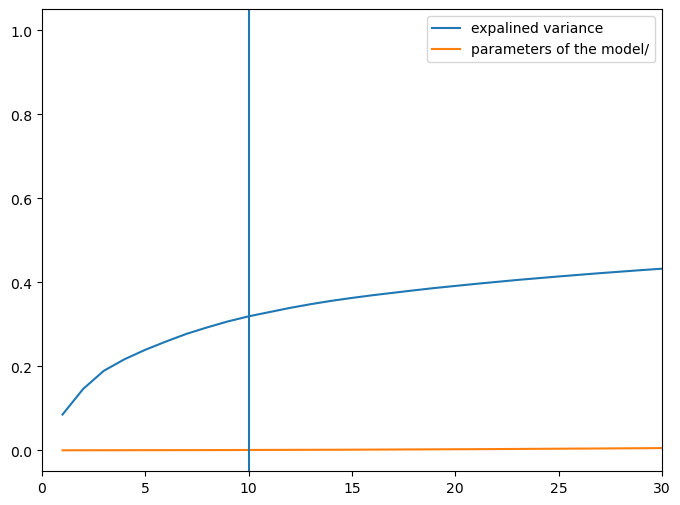

In [456]:
plt.figure(figsize=(8,6))

plt.plot(np.arange(1, n_parcels+1), np.cumsum(explained_variance_ratio), label = 'expalined variance')
plt.plot(np.arange(1, )

plt.plot(np.arange(1, n_parcels+1), num_params_gaussian_hmm(5, np.arange(1, n_parcels+1))/num_params_gaussian_hmm(5, 434), label = 'parameters of the model/')

plt.axvline(10)


plt.legend()
plt.xlim(0, 30)
plt.show()


### Plotting timeseries of the first pca

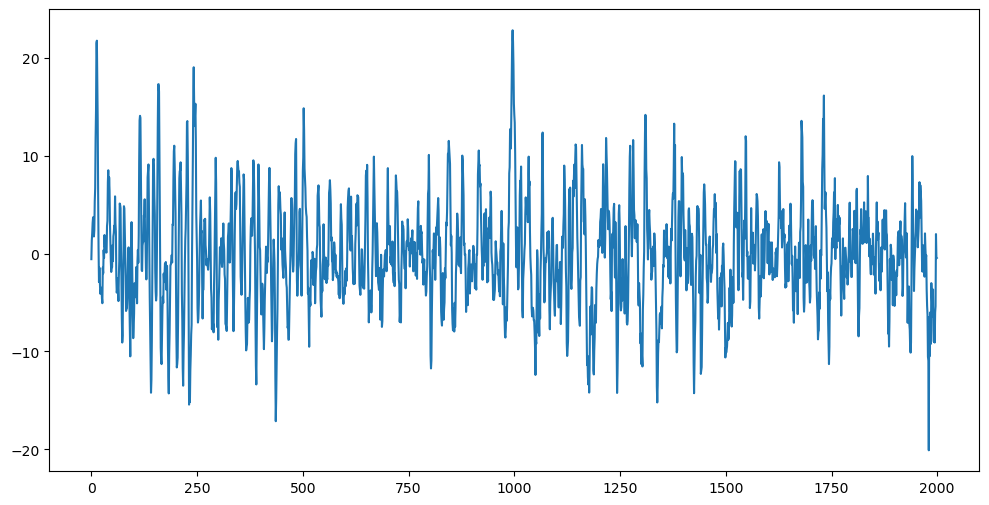

In [211]:
#plotting the time-series of the first pca
plt.figure(figsize=(12, 6))
plt.plot(projections[:2000, 0])
plt.show()

### Number of parameter to estimates

In [209]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1
    transitions = K * (K - 1)
    means = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + means + covs

def num_params_ar_hmm(K, D, P=1):
    init_probs = K - 1
    transitions = K * (K - 1)
    ar_weights = K * D * D * P  # P lags
    biases = K * D
    covs = K * (D * (D + 1)) // 2
    return init_probs + transitions + ar_weights + biases + covs

def num_params_lgssm(D, n):
    # State dynamics
    A = n * n
    Q = (n * (n + 1)) // 2
    # Emission
    C = D * n
    R = (D * (D + 1)) // 2
    # Initial state
    mu0 = n
    Sigma0 = (n * (n + 1)) // 2
    return A + Q + C + R + mu0 + Sigma0

# Example usage:
K = 4   # Number of discrete states
D = 20   # Observation dimension
P = 1   # AR order
n = 3   # Latent state dimension

print("Gaussian HMM params:", num_params_gaussian_hmm(K, D))
print("AR-HMM params:      ", num_params_ar_hmm(K, D, P))
print("LGSSM params:       ", num_params_lgssm(D, n))


Gaussian HMM params: 935
AR-HMM params:       2535
LGSSM params:        294


### HMM parameters

In [216]:
#hyperparameters
n_components = 10
print('Expalined variance considered:', np.cumsum(explained_variance_ratio)[n_components-1])
n_states = 5

Expalined variance considered: 0.31889890051795966


## HMM - Linear Autoregression

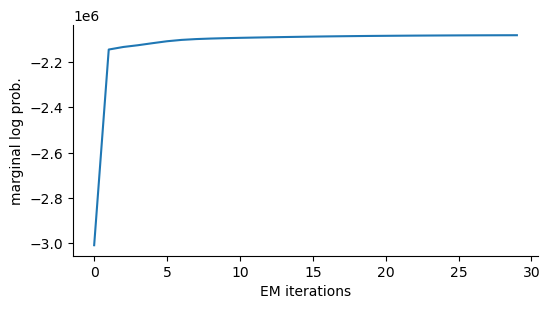

<Figure size 640x480 with 0 Axes>

In [217]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = LinearAutoregressiveHMM(n_states, emissions_dim, num_lags=10)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)

inputs = hmm.compute_inputs(emissions)

#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=30, inputs = inputs)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions, inputs= inputs)

plt.tight_layout()

Subject: 3
Control: 0


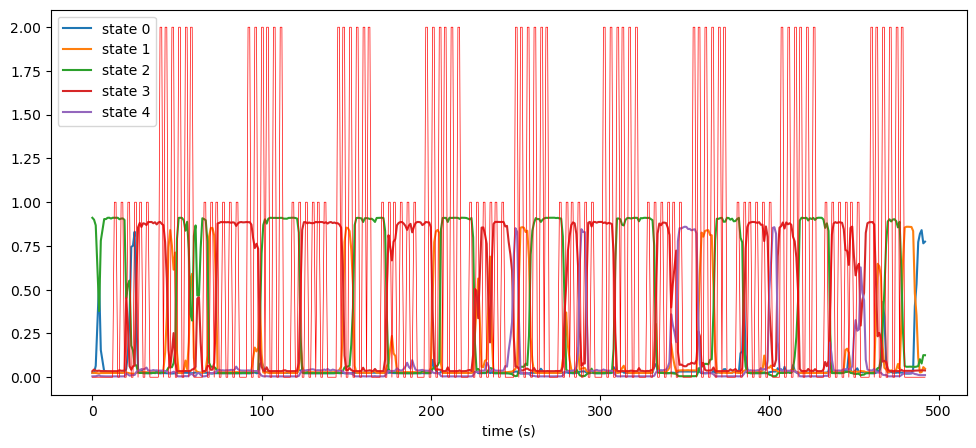

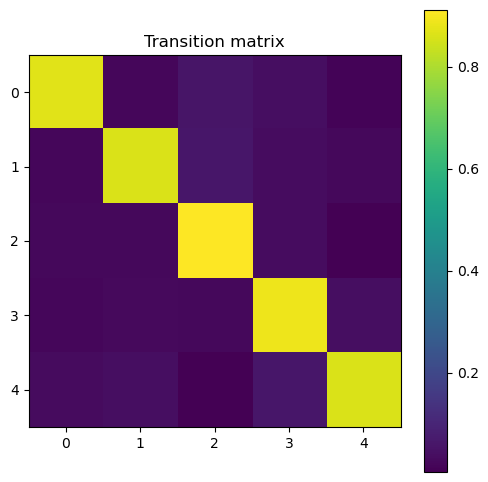

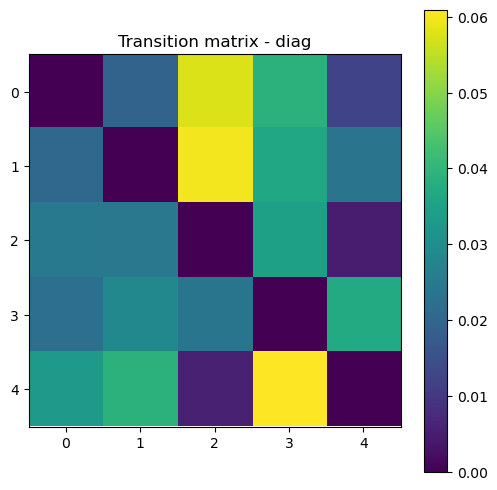

Text(0.5, 0, 'time')

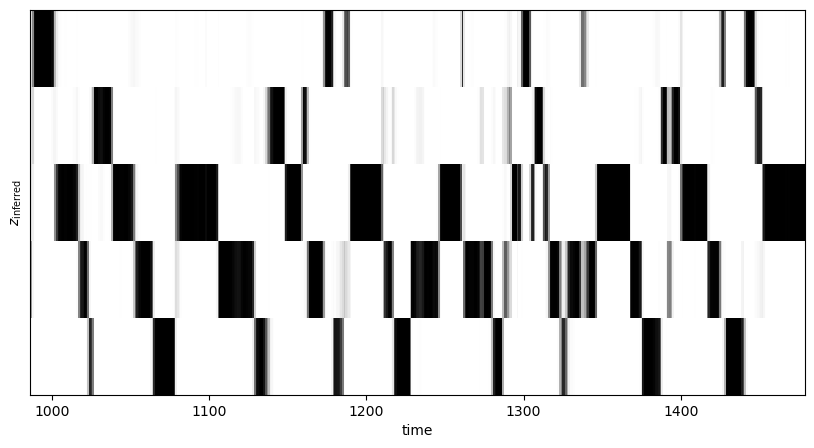

In [262]:
subj = 3

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### Gaussian HMM

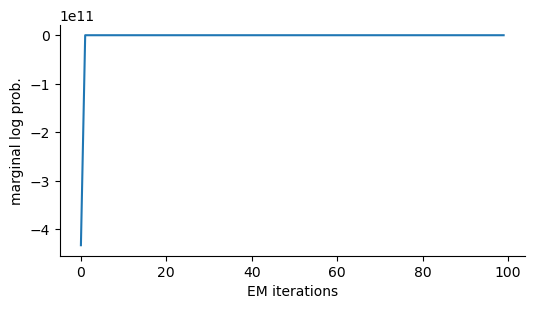

<Figure size 640x480 with 0 Axes>

In [274]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = GaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

Subject: 3
Control: 0


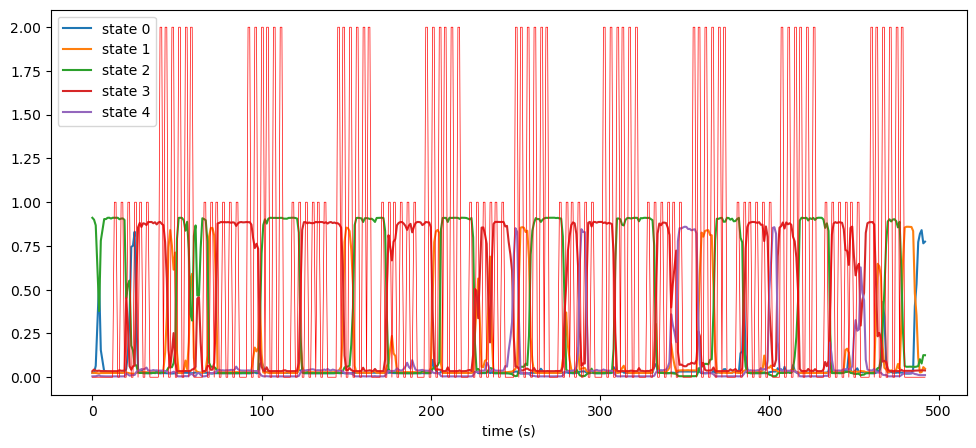

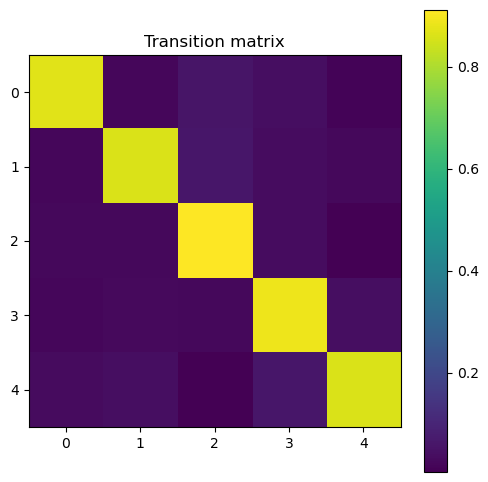

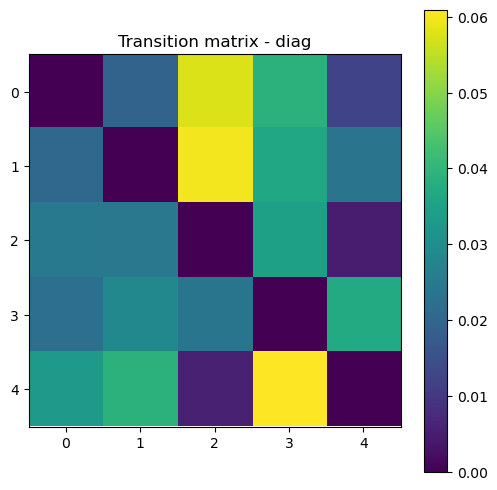

Text(0.5, 0, 'time')

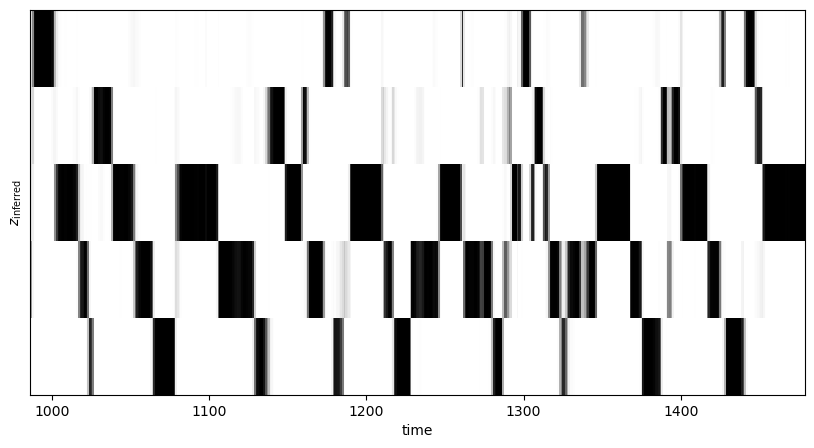

In [275]:
subj = 3

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
row_sums = params_trans.sum(axis=1, keepdims=True)
params_trans = np.divide(params_trans, row_sums, where=row_sums != 0)

plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


### HMM - DiagonalGaussian

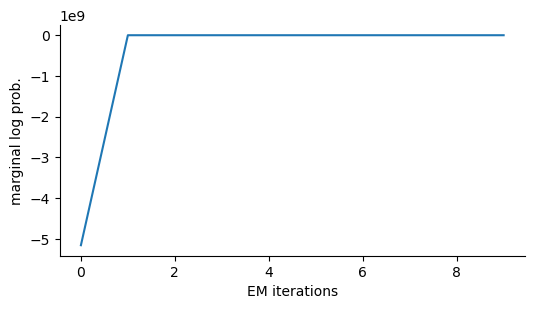

<Figure size 640x480 with 0 Axes>

In [276]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]

hmm = DiagonalGaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

Subject: 45
Control: 1


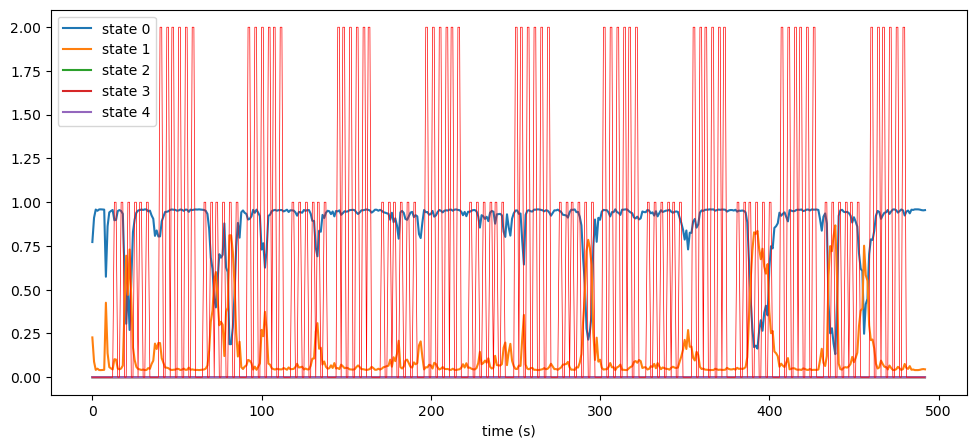

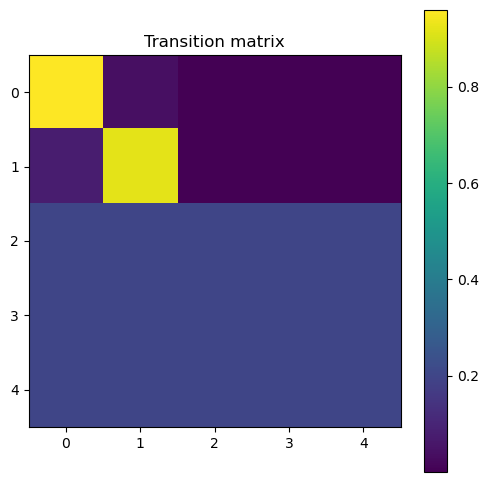

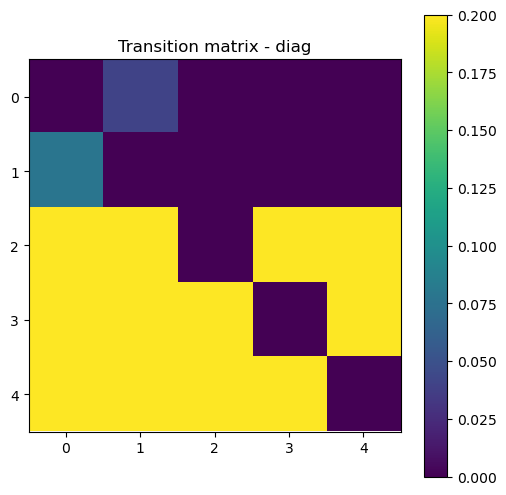

Text(0.5, 0, 'time')

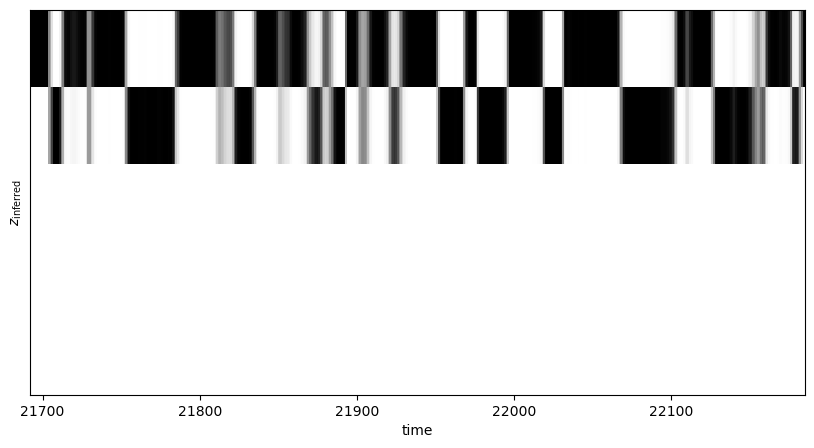

In [278]:
subj = 45

print('Subject:', subj)
print('Control:', controls[subj])

plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[n_time*(subj):n_time*(subj+1), k], label=f'state {k}')
plt.xlabel('time (s)')
plt.plot(stimuli[subj, :], color='r', lw=0.5)
plt.legend()


plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(np.array(params.transitions).squeeze())
plt.colorbar()
plt.title('Transition matrix')
plt.show()


params_trans = np.array(params.transitions).squeeze()
plt.figure(figsize=(6,6))
#plt.imshow(np.log(np.array(params.transitions).squeeze()))
plt.imshow(params_trans - np.diag(np.diag(params_trans)))
plt.colorbar()
plt.title('Transition matrix - diag')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time*(subj-1),n_time*subj)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")


## Model selection

In [389]:
n_components_list = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

n_states_list = np.arange(2, 15)

n_iter = 50

for n_components in n_components_list:
    print(f"Number of components: {n_components}")
    print(f"Explained variance: {np.cumsum(explained_variance_ratio)[n_components-1]}")

Number of components: 10
Explained variance: 0.31889890051795966
Number of components: 12
Explained variance: 0.33899859379952124
Number of components: 14
Explained variance: 0.3558003677134834
Number of components: 16
Explained variance: 0.36920232501495814
Number of components: 18
Explained variance: 0.38081382695360044
Number of components: 20
Explained variance: 0.3914358127049203
Number of components: 22
Explained variance: 0.401031293960377
Number of components: 24
Explained variance: 0.4097946742095323
Number of components: 26
Explained variance: 0.41789870286004377
Number of components: 28
Explained variance: 0.42544372253150514
Number of components: 30
Explained variance: 0.4323875531511956


In [390]:
def training(n_components, n_states, projections, n_iter=10):
    
    emissions = projections[:, :n_components]
    emissions_dim = emissions.shape[1]


    hmm = GaussianHMM(n_states, emissions_dim)

    ### Fit it with EM
    params, props = hmm.initialize(emissions=emissions)


    #params, props = hmm.initialize(emissions=emissions)
    params, lls = hmm.fit_em(params, props, emissions, num_iters=n_iter)

    return [n_components, n_states, params, lls]

In [391]:
print('Number of models:', len(n_components_list) * len(n_states_list))
results = Parallel(n_jobs=-1, verbose = 11)(delayed(training)(n_components, n_states, projections, n_iter=n_iter) for n_components in n_components_list for n_states in n_states_list)

Number of models: 143


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/home/zenari/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


2025-04-10 12:54:11.702609: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-04-10 12:54:11.771589: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_gene

2025-04-10 12:54:13.028377: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.32587456s
Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-04-10 12:54:13.034867: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.263402742s
Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metad

2025-04-10 12:54:13.758912: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


2025-04-10 12:54:14.374186: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.615388265s
Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[100,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   55.4s


[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   59.1s


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   59.8s


[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  1.0min


2025-04-10 12:54:49.698799: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[144,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
2025-04-10 12:54:50.831796: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.140376458s
Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[144,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
2025-04-10 12:54:51.184174: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[144,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.1min


2025-04-10 12:54:52.713588: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.529533634s
Constant folding an instruction is taking > 1s:

  %reshape.111 = f32[144,107967]{1,0} reshape(%constant.404), metadata={op_name="jit(em_step)/jit(main)/vmap(tk,ti,tj->kij)/dot_general" source_file="/tmp/ipykernel_138472/4251360999.py" source_line=14}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.


[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  23 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  27 tasks      | elapsed:  1.5min


/home/zenari/miniconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min


[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  1.7min


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.8min


[Parallel(n_jobs=-1)]: Done  31 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:  1.8min


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:  1.9min


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.0min


[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed:  2.0min


[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:  2.1min


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed:  2.1min


[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  2.1min


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.2min


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.2min


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:  2.5min


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.7min


[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:  2.7min


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.9min


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.1min


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  59 tasks      | elapsed:  3.2min


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.3min


[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  63 tasks      | elapsed:  3.3min


[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.4min


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  3.5min


[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:  3.5min


[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:  3.6min


[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:  3.7min


[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  3.9min


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.0min


[Parallel(n_jobs=-1)]: Done  75 tasks      | elapsed:  4.2min


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:  4.2min


[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  4.3min


[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:  4.4min


[Parallel(n_jobs=-1)]: Done  79 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  4.5min


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:  4.7min


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:  4.8min


[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:  4.9min


[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:  4.9min


[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:  5.0min


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  5.0min


[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  5.1min


[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.1min


[Parallel(n_jobs=-1)]: Done  91 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:  5.3min


[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:  5.4min


[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.4min


[Parallel(n_jobs=-1)]: Done  95 tasks      | elapsed:  5.6min


[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  5.7min


[Parallel(n_jobs=-1)]: Done 110 out of 143 | elapsed:  6.7min remaining:  2.0min


[Parallel(n_jobs=-1)]: Done 124 out of 143 | elapsed:  8.2min remaining:  1.3min


[Parallel(n_jobs=-1)]: Done 138 out of 143 | elapsed:  9.1min remaining:   19.7s
[Parallel(n_jobs=-1)]: Done 143 out of 143 | elapsed:  9.3min finished


In [392]:
def num_params_gaussian_hmm(K, D):
    init_probs = K - 1                  # Initial state probs (sum to 1)
    transitions = K * (K - 1)           # Rows of transition matrix sum to 1
    means = K * D                       # One mean vector per state
    covs = K * D * (D + 1) // 2         # One full cov matrix per state
    return init_probs + transitions + means + covs


In [393]:
heatmap_data = []
for line in results:
    n_states, n_components, params, lls = line
     # Compute BIC
    num_params = num_params_gaussian_hmm(n_states, n_components)
    bic = -2 * lls[-1].item()/n_states + np.log(total_time_points) * num_params
    heatmap_data.append([n_states, n_components, bic])

heatmap_data = np.array(heatmap_data)
heatmap = heatmap_data[:, 2].reshape(len(n_components_list), len(n_states_list))

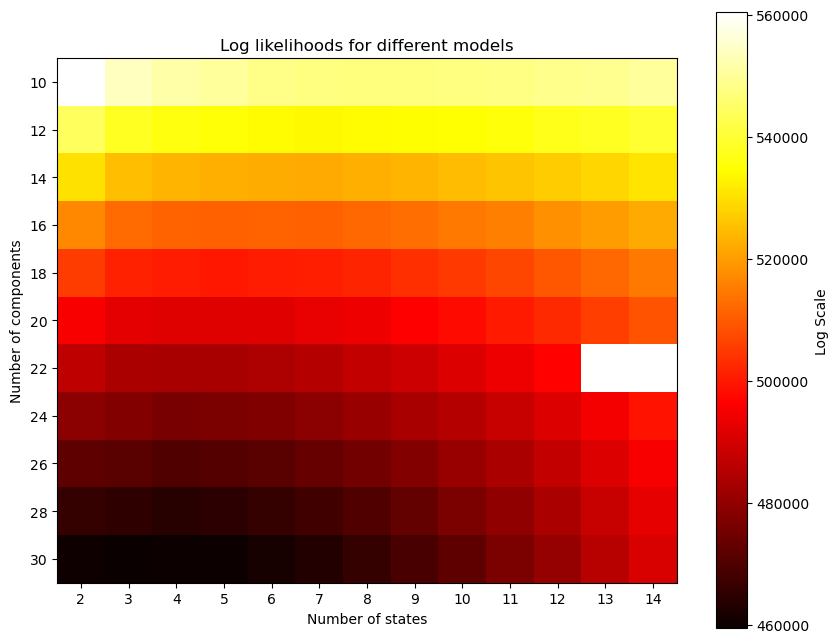

In [394]:
plt.figure(figsize=(10, 8))
img = plt.imshow(heatmap, cmap='hot')
plt.colorbar(img, label='Log Scale')
plt.xticks(np.arange(len(n_states_list)), n_states_list)
plt.yticks(np.arange(len(n_components_list)), n_components_list)
plt.xlabel('Number of states')
plt.ylabel('Number of components')
plt.title('Log likelihoods for different models')
plt.show()

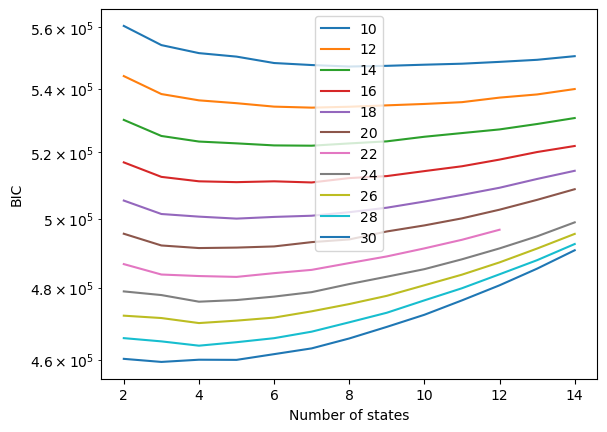

In [395]:
for chosen_n_comp in range(len(n_components_list)):
    plt.plot(n_states_list, heatmap[chosen_n_comp, :], label=n_components_list[chosen_n_comp])
    plt.xlabel('Number of states')
    plt.ylabel('BIC')
plt.legend()
plt.yscale('log')

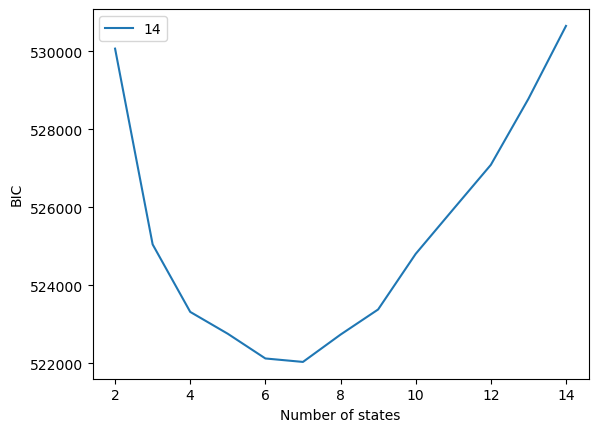

In [421]:
chosen_n_comp = 2
plt.plot(n_states_list, heatmap[chosen_n_comp, :], label=n_components_list[chosen_n_comp])
plt.xlabel('Number of states')
plt.ylabel('BIC')
plt.legend()

In [320]:
lls[-1]

Array(-9884378., dtype=float32)

In [ ]:
emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]


hmm = GaussianHMM(n_states, emissions_dim)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)


#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


post = hmm.smoother(params, emissions)

plt.tight_layout()

## Interpreting the states

In [114]:
means = params.emissions.means
covs = params.emissions.covs

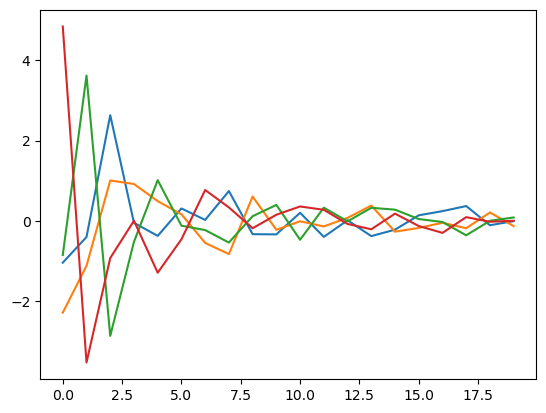

In [115]:
plt.plot(means.T)

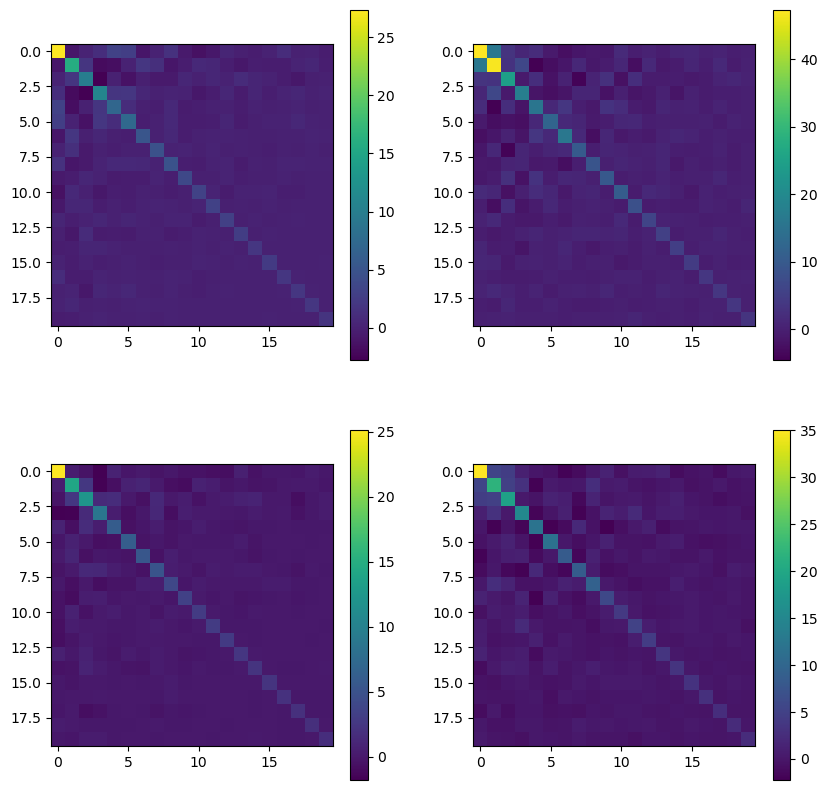

In [116]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
im1 = ax[0, 0].imshow(covs[0])
ax[0, 0].figure.colorbar(im1, ax=ax[0, 0])
im2 = ax[0, 1].imshow(covs[1])
ax[0, 1].figure.colorbar(im2, ax=ax[0, 1])
im3 = ax[1, 0].imshow(covs[2])
ax[1, 0].figure.colorbar(im3, ax=ax[1, 0])
im4 = ax[1, 1].imshow(covs[3])
ax[1, 1].figure.colorbar(im4, ax=ax[1, 1])


In [117]:
post_probs = post.predicted_probs

print(post_probs.shape)

(107967, 4)


In [118]:
occupied_state = np.argmax(post_probs, axis = 1)
occupied_state.shape

(107967,)

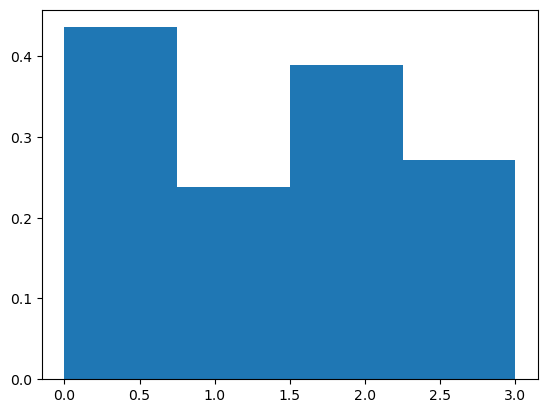

In [119]:
#frequency of occupancy
plt.hist(occupied_state, bins = 4, density = True)
plt.show()

In [131]:
from itertools import groupby

def find_runs(arr):
    runs = []
    start = 0
    for value, group in groupby(arr):
        length = len(list(group))
        end = start + length
        runs.append((value, end-start))  # (valore, inizio, fine)
        start = end
    return runs

arr = [2, 2, 3, 3, 3, 1, 1, 2, 2, 2, 2]
runs = find_runs(occupied_state)

Array(1, dtype=int32)

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2)

# Plot your data on subplots

# Add colorbars to subplots
cbar1 = fig.colorbar(im1, ax=axs[0, 0])
cbar2 = fig.colorbar(im2, ax=axs[0, 1])
cbar3 = fig.colorbar(im3, ax=axs[1, 0])
cbar4 = fig.colorbar(im4, ax=axs[1, 1])

# Show the plot
plt.show()


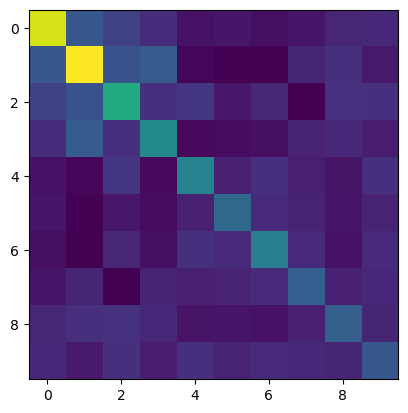

In [46]:
plt.imshow(covs[0])

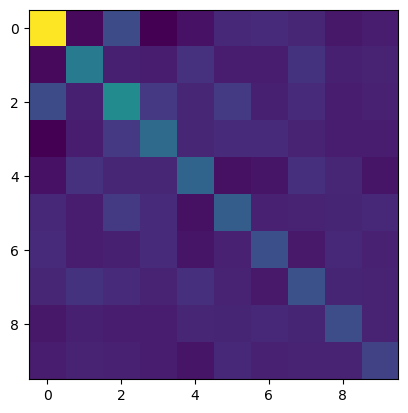

In [47]:
plt.imshow(covs[1])

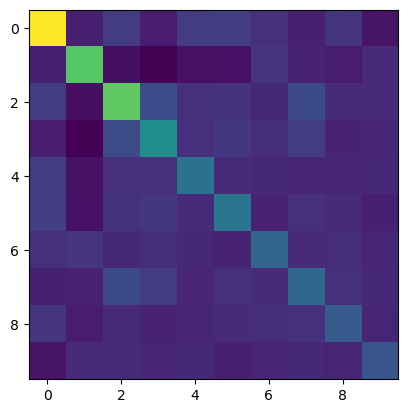

In [49]:
plt.imshow(covs[2])

In [ ]:
plt.imshow(covs[3])

In [440]:
# Initialize PCA
pca = PCA(n_components=n_components)

# Fit and transform the signal
projections = pca.fit_transform(x)

# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# eigenvectors
eigenvectors = pca.components_

In [441]:
### Transform states from pc to original space
means = params.emissions.means
covs = params.emissions.covs

print(means.shape, covs.shape)

means_orig = pca.inverse_transform(params.emissions.means)
cov_orig = np.stack( [pca.components_.T @ tmp_cov @ pca.components_ for tmp_cov in covs] )
print(means_orig.shape, cov_orig.shape)

#np.save(folder_results+f'mean_n_{num_states}_comp_{n_components}.npy', means_orig)
#np.save(folder_results+f'cov_n_{num_states}_comp_{n_components}.npy', cov_orig)

(4, 10) (4, 10, 10)


(4, 48800) (4, 48800, 48800)


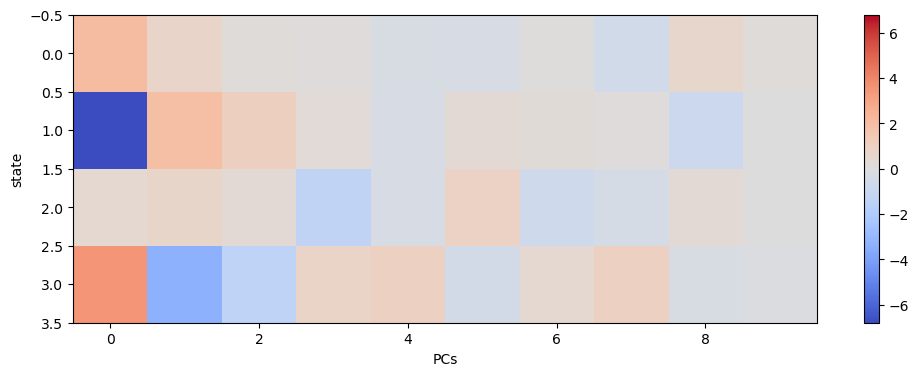

In [443]:
vmax = np.abs(means).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('PCs')
plt.show()

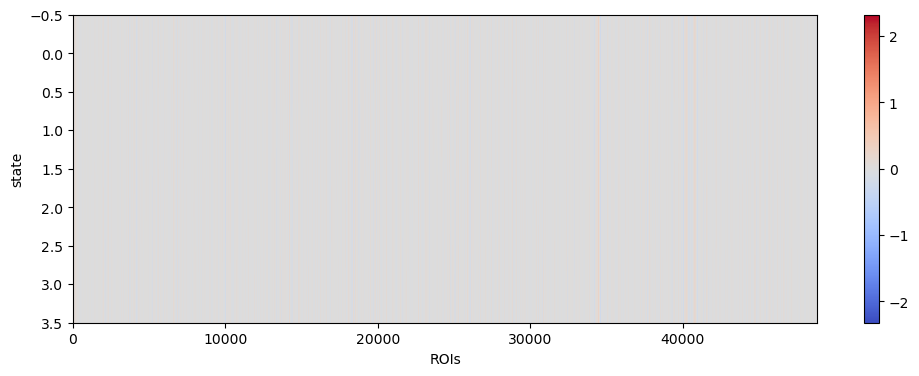

In [444]:
vmax = np.abs(means_orig).max()
vmin = -vmax
plt.figure(figsize=(12,4))
plt.imshow(means_orig, aspect='auto', vmin=vmin, vmax=vmax, cmap='coolwarm')
plt.colorbar()
plt.ylabel('state')
plt.xlabel('ROIs')
plt.show()